In [26]:
import numpy as np
from typing import List

class LifiAccessPoint:
    def __init__(self, x, y, Φ_1by2=60, Apd=100*1e-4, ref_index=1.5, FOV=90, gf=1,
            room_x=5, room_y=5, room_z=5, h=0.8, Rpd=0.53, pw=0.8, Popt=3, k=3, Nlifi=1e-21, Blifi=20*1e6):
        # attribute for Half-intensity radiation angle (Φ1/2)
        self.Φ_1by2 = Φ_1by2 * np.pi / 180
        self.m = -np.log(2) / np.log(np.cos(np.radians(Φ_1by2)))
        # Refractive ref_index of the medium
        self.ref_index = ref_index
        # FoV semi-angle of PD, Ψmax
        self.FOV = FOV * np.pi / 180
        # physical area of the PD, Apd
        self.Apd = Apd
        # gain of the optical filter, gf
        self.gf = gf
        # length of the room in the x-direction (horizontal) in meters.
        self.room_x = room_x
        # length of the room in the y-direction (vertical) in meters.
        self.room_y = room_y
        # height of the room in meters
        self.room_z = room_z
        # height of the user above the receiver plane
        self.h = h
        # position of the lifi access point in ceiling
        self.lifi_position = np.array([x, y, room_z])
        # Detector responsivity, Rpd
        self.Rpd = Rpd
        # Transmitted optical power per LiFi AP, Popt
        self.Popt = Popt
        # optical to electrical conversion coefficient, k
        self.k = k
        # PSD of noise in LiFi AP, NLiFi
        self.Nlifi = Nlifi
        # Bandwidth of LiFi AP, BLiFi
        self.Blifi = Blifi
        # Wall reflectivity, pw
        self.pw = pw
        
        # Number of points in the x and y directions
        # self.Nx = int(room_x * 10)
        # self.Ny = int(room_y * 10)
        # self.x = np.linspace(0, room_x, self.Nx)
        # self.y = np.linspace(0, room_y, self.Ny)
        # self.XR, self.YR = np.meshgrid(self.x, self.y)
        # print(self.XR)
        # print(self.XR.shape)

    def get_channel_gain(self, user_x, user_y):
        # uncomment this line to include NLOS channel gain
        return self.channel_gain_los(user_x, user_y) #+ self.channel_gain_nlos(user_x, user_y)

    def channel_gain_los(self, user_x, user_y):
        d = self.distance(user_x, user_y)        
        # both angles are equal due to symmetry
        incidence = self.angle_incidence(user_x, user_y)
        irradiance = incidence           
        gc = self.optical_gain(incidence)
        channel_gain = ((self.m + 1) * self.Apd * (np.cos(irradiance)**self.m) * np.cos(incidence) * self.gf * gc) / (2 * np.pi * (d**2))
        # print(incidence, irradiance, channel_gain, self.m, gc, self.Apd, self.gf)
        return channel_gain
    
    def channel_gain_nlos(self, user_x, user_y):
        boxes_per_meter = 10
        dl, dh = 1/boxes_per_meter, 1/boxes_per_meter
        height_coord = np.arange(self.h, self.room_z, dh)
        length_coord = np.arange(self.h, self.room_x, dl)
        user_position = np.array([user_x, user_y, self.h])
        integration = 0
        
        for height in height_coord:
            # print(f'{height:.3f}  ')
            for length in length_coord:
                locations = [np.array([length, 0, height]), np.array([length, self.room_y, height]),
                            np.array([0, length, height]), np.array([self.room_x, length, height])]
                for curr_location in locations:
                    d_iw = np.linalg.norm(curr_location - self.lifi_position)
                    d_wu = np.linalg.norm(user_position - curr_location)
                    theta_iw = np.arccos((self.room_z - height) / d_iw)
                    ϑ_iw = 90 - theta_iw
                    # print(f'd_iw: {d_iw}, d_wu: {d_wu}, theta_iw: {theta_iw}, ϑ_iw: {ϑ_iw}')
                    phi_wu = np.arccos((height - self.h) / d_wu)
                    ϑ_wu = 90 - phi_wu
                    numerator = (self.m + 1) * self.Apd * self.pw * (np.cos(theta_iw)**self.m) * \
                                self.gf * self.optical_gain(phi_wu) * np.cos(phi_wu) * np.cos(ϑ_iw) * np.cos(ϑ_wu)
                    integration += (numerator * dl * dh) / (2 * (np.pi * d_iw * d_wu)**2)
        return integration
    
    def signal_to_noise_ratio(self, user_x, user_y, otherLifiAPs:List):
        summation_term = 0
        # for lifi in otherLifiAPs:
        #     # print(f'Lifi at {lifi.lifi_position} has gain', lifi.get_channel_gain(user_x, user_y))
        #     summation_term += (lifi.Rpd * lifi.get_channel_gain(user_x, user_y) * lifi.Popt / lifi.k) ** 2
        # print('self gain: ', self.get_channel_gain(user_x, user_y))
        numerator = (self.Rpd * self.get_channel_gain(user_x, user_y) * self.Popt / self.k) ** 2
        # uncomment this line to include noise from other LiFi APs
        denominator = self.Nlifi * self.Blifi + summation_term 
        # print(f'numerator: {numerator}, denominator: {denominator}, sum: {summation_term}')   
        return numerator / denominator
    
    def distance(self, user_x, user_y):
        user_position = np.array([user_x, user_y, self.h])
        distance =  np.linalg.norm(user_position - self.lifi_position)
        return distance
    
    def optical_gain(self, angle_incidence):
        if 0 <= angle_incidence <= self.FOV:
            return (self.ref_index**2) / (np.sin(self.FOV)**2)
        else:
            return 0
    
    def angle_incidence(self, user_x, user_y):
        d = self.distance(user_x, user_y)
        return np.arccos((self.room_z - self.h) / d)





In [27]:
# if __name__ == "__main__":
#     x, y = 1.25, 1.25
#     lifi_ap1 = LifiAccessPoint(x=1.25, y=1.25)
#     # lifi_ap2 = LifiAccessPoint(x=1.25, y=3.75)
#     # lifi_ap3 = LifiAccessPoint(x=3.75, y=3.75)
#     # lifi_ap4 = LifiAccessPoint(x=3.75, y=1.25)

#     # ang_incidence = lifi_ap1.angle_incidence(x, y)
#     # optical_gain = lifi_ap1.optical_gain(ang_incidence)
#     # # print(ang_incidence)
#     # # print(optical_gain)
#     # # H = lifi_ap1.get_channel_gain(x, y)
    
#     # print('Location: ', 0, 0)
#     # snr = lifi_ap1.signal_to_noise_ratio(0, 0, otherLifiAPs=[lifi_ap2, lifi_ap3, lifi_ap4])
#     # print(snr)
#     # print('Location: ', 1.25, 1.25)
#     # snr = lifi_ap1.signal_to_noise_ratio(1.2, 1.2, otherLifiAPs=[lifi_ap2, lifi_ap3, lifi_ap4])
#     # print(snr)

In [28]:
x, y = 1.25, 1.25
lifi_ap1 = LifiAccessPoint(x=1.25, y=1.25)

In [9]:
room_width = 5.0
room_height = 5.0
user_height = 0.8

# Divide the floor into 0.1x0.1m squares
grid_size = 0.1
# x_grid = np.arange(0, room_width, grid_size)
# y_grid = np.arange(0, room_height, grid_size)
x_grid = [round(i * grid_size, 1) for i in range(int(room_width / grid_size) + 1)]
y_grid = [round(i * grid_size, 1) for i in range(int(room_height / grid_size) + 1)]

print(f"Number of squares in x-direction: {len(x_grid)}")
print(f"Number of squares in y-direction: {len(y_grid)}")
print(f"Total number of squares: {len(x_grid) * len(y_grid)}")
print()
print("Grid points:")
# print(list(zip(x_grid, y_grid)))
# make list of all ombination of x and y
grid_points = [(x, y) for x in x_grid for y in y_grid]
print(grid_points)

Number of squares in x-direction: 51
Number of squares in y-direction: 51
Total number of squares: 2601

Grid points:
[(0.0, 0.0), (0.0, 0.1), (0.0, 0.2), (0.0, 0.3), (0.0, 0.4), (0.0, 0.5), (0.0, 0.6), (0.0, 0.7), (0.0, 0.8), (0.0, 0.9), (0.0, 1.0), (0.0, 1.1), (0.0, 1.2), (0.0, 1.3), (0.0, 1.4), (0.0, 1.5), (0.0, 1.6), (0.0, 1.7), (0.0, 1.8), (0.0, 1.9), (0.0, 2.0), (0.0, 2.1), (0.0, 2.2), (0.0, 2.3), (0.0, 2.4), (0.0, 2.5), (0.0, 2.6), (0.0, 2.7), (0.0, 2.8), (0.0, 2.9), (0.0, 3.0), (0.0, 3.1), (0.0, 3.2), (0.0, 3.3), (0.0, 3.4), (0.0, 3.5), (0.0, 3.6), (0.0, 3.7), (0.0, 3.8), (0.0, 3.9), (0.0, 4.0), (0.0, 4.1), (0.0, 4.2), (0.0, 4.3), (0.0, 4.4), (0.0, 4.5), (0.0, 4.6), (0.0, 4.7), (0.0, 4.8), (0.0, 4.9), (0.0, 5.0), (0.1, 0.0), (0.1, 0.1), (0.1, 0.2), (0.1, 0.3), (0.1, 0.4), (0.1, 0.5), (0.1, 0.6), (0.1, 0.7), (0.1, 0.8), (0.1, 0.9), (0.1, 1.0), (0.1, 1.1), (0.1, 1.2), (0.1, 1.3), (0.1, 1.4), (0.1, 1.5), (0.1, 1.6), (0.1, 1.7), (0.1, 1.8), (0.1, 1.9), (0.1, 2.0), (0.1, 2.1), (0.1,

In [29]:
room_length = 5.0
room_breadth = 5.0
cell_dimension = 0.1

# Calculate the number of cells in each dimension
num_cells_x = int(room_length / cell_dimension)
num_cells_y = int(room_breadth / cell_dimension)

# Find midpoints of each cell
midpoints = []

for i in range(num_cells_x):
    for j in range(num_cells_y):
        x = i * cell_dimension + cell_dimension / 2
        y = j * cell_dimension + cell_dimension / 2
        midpoints.append((round(x, 2), round(y, 2)))

print("Number of cells in x-direction:", num_cells_x)
print("Number of cells in y-direction:", num_cells_y)
print("Total number of cells:", num_cells_x * num_cells_y)
print("\nMidpoints of each cell:")
print(midpoints)


Number of cells in x-direction: 50
Number of cells in y-direction: 50
Total number of cells: 2500

Midpoints of each cell:
[(0.05, 0.05), (0.05, 0.15), (0.05, 0.25), (0.05, 0.35), (0.05, 0.45), (0.05, 0.55), (0.05, 0.65), (0.05, 0.75), (0.05, 0.85), (0.05, 0.95), (0.05, 1.05), (0.05, 1.15), (0.05, 1.25), (0.05, 1.35), (0.05, 1.45), (0.05, 1.55), (0.05, 1.65), (0.05, 1.75), (0.05, 1.85), (0.05, 1.95), (0.05, 2.05), (0.05, 2.15), (0.05, 2.25), (0.05, 2.35), (0.05, 2.45), (0.05, 2.55), (0.05, 2.65), (0.05, 2.75), (0.05, 2.85), (0.05, 2.95), (0.05, 3.05), (0.05, 3.15), (0.05, 3.25), (0.05, 3.35), (0.05, 3.45), (0.05, 3.55), (0.05, 3.65), (0.05, 3.75), (0.05, 3.85), (0.05, 3.95), (0.05, 4.05), (0.05, 4.15), (0.05, 4.25), (0.05, 4.35), (0.05, 4.45), (0.05, 4.55), (0.05, 4.65), (0.05, 4.75), (0.05, 4.85), (0.05, 4.95), (0.15, 0.05), (0.15, 0.15), (0.15, 0.25), (0.15, 0.35), (0.15, 0.45), (0.15, 0.55), (0.15, 0.65), (0.15, 0.75), (0.15, 0.85), (0.15, 0.95), (0.15, 1.05), (0.15, 1.15), (0.15, 1

In [30]:
d = {}
for x, y in midpoints:
    d[(x, y)] = lifi_ap1.channel_gain_nlos(x, y)

In [12]:
for i,j in d.items():
    #if j=nan then assign 0
    if np.isnan(j):
        d[i]=0

In [31]:
d

{(0.05, 0.05): 4.519505902852275e-06,
 (0.05, 0.15): 3.5918014949313057e-06,
 (0.05, 0.25): 2.61002887025805e-06,
 (0.05, 0.35): 1.5440550644352549e-06,
 (0.05, 0.45): 3.5233518927686316e-07,
 (0.05, 0.55): -1.020509716765157e-06,
 (0.05, 0.65): -2.5827038009883965e-06,
 (0.05, 0.75): -2.7386122252887994e-06,
 (0.05, 0.85): -2.7503604515371304e-06,
 (0.05, 0.95): -3.988189733909279e-06,
 (0.05, 1.05): -4.968551798163456e-06,
 (0.05, 1.15): -5.701483662853236e-06,
 (0.05, 1.25): -6.2367172713414386e-06,
 (0.05, 1.35): -6.608254125284101e-06,
 (0.05, 1.45): -6.838436984396666e-06,
 (0.05, 1.55): -6.941812047511673e-06,
 (0.05, 1.65): -6.927559342385101e-06,
 (0.05, 1.75): -6.801180769530554e-06,
 (0.05, 1.85): -6.5658117030235955e-06,
 (0.05, 1.95): -6.2232983752130965e-06,
 (0.05, 2.05): -5.775085094385303e-06,
 (0.05, 2.15): -5.222920939256606e-06,
 (0.05, 2.25): -4.569389310353414e-06,
 (0.05, 2.35): -3.818267922497112e-06,
 (0.05, 2.45): -2.974733302859847e-06,
 (0.05, 2.55): -2.0454

In [34]:
import json
with open('channel_gain_nlos_mids.json', 'w') as fp:
    json.dump(d, fp, indent=4)

In [33]:
# change the keys to string
d = {str(k): v for k, v in d.items()}

In [ ]:
d

In [ ]:
import numpy as np

# Original grid points
grid_points = [(i / 10, j / 10) for i in range(51) for j in range(51)]

# Convert grid points to a NumPy array
matrix = np.array(grid_points)

# Reshape the matrix to a 2D array
matrix_2d = matrix.reshape((51, 51, 2))

# Rotate the matrix to the right
rotated_matrix_2d = np.rot90(matrix_2d, k=-1)

# Reshape the rotated matrix back to a 1D array
rotated_matrix = rotated_matrix_2d.reshape(-1, 2)

# Print the older vs. new points mapping
print("Original Points\t\t\t\t\t\t\t\t\t\tRotated Points")
print("-----------------------------------------------------------------")
for original, rotated in zip(matrix, rotated_matrix):
    print(f"{original}\t\t\t\t\t\t\t\t\t\t{rotated}")


In [22]:
room_length = 5.0
room_breadth = 5.0
cell_dimension = 0.1

# Calculate the number of cells in each dimension
num_cells_x = int(room_length / cell_dimension)
num_cells_y = int(room_breadth / cell_dimension)

# Find midpoints of each cell
midpoints = []

for i in range(num_cells_x):
    for j in range(num_cells_y):
        x = i * cell_dimension + cell_dimension / 2
        y = j * cell_dimension + cell_dimension / 2
        midpoints.append((round(x, 2), round(y, 2)))

print("Number of cells in x-direction:", num_cells_x)
print("Number of cells in y-direction:", num_cells_y)
print("Total number of cells:", num_cells_x * num_cells_y)
print("\nMidpoints of each cell:")
print(midpoints)


Number of cells in x-direction: 50
Number of cells in y-direction: 50
Total number of cells: 2500

Midpoints of each cell:
[(0.05, 0.05), (0.05, 0.15), (0.05, 0.25), (0.05, 0.35), (0.05, 0.45), (0.05, 0.55), (0.05, 0.65), (0.05, 0.75), (0.05, 0.85), (0.05, 0.95), (0.05, 1.05), (0.05, 1.15), (0.05, 1.25), (0.05, 1.35), (0.05, 1.45), (0.05, 1.55), (0.05, 1.65), (0.05, 1.75), (0.05, 1.85), (0.05, 1.95), (0.05, 2.05), (0.05, 2.15), (0.05, 2.25), (0.05, 2.35), (0.05, 2.45), (0.05, 2.55), (0.05, 2.65), (0.05, 2.75), (0.05, 2.85), (0.05, 2.95), (0.05, 3.05), (0.05, 3.15), (0.05, 3.25), (0.05, 3.35), (0.05, 3.45), (0.05, 3.55), (0.05, 3.65), (0.05, 3.75), (0.05, 3.85), (0.05, 3.95), (0.05, 4.05), (0.05, 4.15), (0.05, 4.25), (0.05, 4.35), (0.05, 4.45), (0.05, 4.55), (0.05, 4.65), (0.05, 4.75), (0.05, 4.85), (0.05, 4.95), (0.15, 0.05), (0.15, 0.15), (0.15, 0.25), (0.15, 0.35), (0.15, 0.45), (0.15, 0.55), (0.15, 0.65), (0.15, 0.75), (0.15, 0.85), (0.15, 0.95), (0.15, 1.05), (0.15, 1.15), (0.15, 1

In [35]:
midpoints_mat = np.array(midpoints).reshape((50, 50, 2))

In [37]:
midpoints_mat.shape

(50, 50, 2)

In [62]:
#rotate the matrix by 90 degree
rotated_midpoints_mat = np.rot90(midpoints_mat, k=-3)

In [63]:
print(list(zip(midpoints_mat[0], rotated_midpoints_mat[0])))

[(array([0.05, 0.05]), array([0.05, 4.95])), (array([0.05, 0.15]), array([0.15, 4.95])), (array([0.05, 0.25]), array([0.25, 4.95])), (array([0.05, 0.35]), array([0.35, 4.95])), (array([0.05, 0.45]), array([0.45, 4.95])), (array([0.05, 0.55]), array([0.55, 4.95])), (array([0.05, 0.65]), array([0.65, 4.95])), (array([0.05, 0.75]), array([0.75, 4.95])), (array([0.05, 0.85]), array([0.85, 4.95])), (array([0.05, 0.95]), array([0.95, 4.95])), (array([0.05, 1.05]), array([1.05, 4.95])), (array([0.05, 1.15]), array([1.15, 4.95])), (array([0.05, 1.25]), array([1.25, 4.95])), (array([0.05, 1.35]), array([1.35, 4.95])), (array([0.05, 1.45]), array([1.45, 4.95])), (array([0.05, 1.55]), array([1.55, 4.95])), (array([0.05, 1.65]), array([1.65, 4.95])), (array([0.05, 1.75]), array([1.75, 4.95])), (array([0.05, 1.85]), array([1.85, 4.95])), (array([0.05, 1.95]), array([1.95, 4.95])), (array([0.05, 2.05]), array([2.05, 4.95])), (array([0.05, 2.15]), array([2.15, 4.95])), (array([0.05, 2.25]), array([2.

In [64]:
d_125_375 = {}
for i in range(len(midpoints_mat)):
    for j in range(len(midpoints_mat)):
        d_125_375[(rotated_midpoints_mat[i][j][0], rotated_midpoints_mat[i][j][1])] = d[str((midpoints_mat[i][j][0], midpoints_mat[i][j][1]))]

In [65]:
# change the keys to string
d_125_375 = {str(k): v for k, v in d_125_375.items()}

In [66]:
d_125_375

{'(0.05, 4.95)': 4.519505902852275e-06,
 '(0.15, 4.95)': 3.5918014949313057e-06,
 '(0.25, 4.95)': 2.61002887025805e-06,
 '(0.35, 4.95)': 1.5440550644352549e-06,
 '(0.45, 4.95)': 3.5233518927686316e-07,
 '(0.55, 4.95)': -1.020509716765157e-06,
 '(0.65, 4.95)': -2.5827038009883965e-06,
 '(0.75, 4.95)': -2.7386122252887994e-06,
 '(0.85, 4.95)': -2.7503604515371304e-06,
 '(0.95, 4.95)': -3.988189733909279e-06,
 '(1.05, 4.95)': -4.968551798163456e-06,
 '(1.15, 4.95)': -5.701483662853236e-06,
 '(1.25, 4.95)': -6.2367172713414386e-06,
 '(1.35, 4.95)': -6.608254125284101e-06,
 '(1.45, 4.95)': -6.838436984396666e-06,
 '(1.55, 4.95)': -6.941812047511673e-06,
 '(1.65, 4.95)': -6.927559342385101e-06,
 '(1.75, 4.95)': -6.801180769530554e-06,
 '(1.85, 4.95)': -6.5658117030235955e-06,
 '(1.95, 4.95)': -6.2232983752130965e-06,
 '(2.05, 4.95)': -5.775085094385303e-06,
 '(2.15, 4.95)': -5.222920939256606e-06,
 '(2.25, 4.95)': -4.569389310353414e-06,
 '(2.35, 4.95)': -3.818267922497112e-06,
 '(2.45, 4.95

In [61]:
import json
with open('channel_gain_nlos_mids_125_375.json', 'w') as fp:
    json.dump(d_125_375, fp, indent=4)

In [2]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Average Throughput (Mbps)')

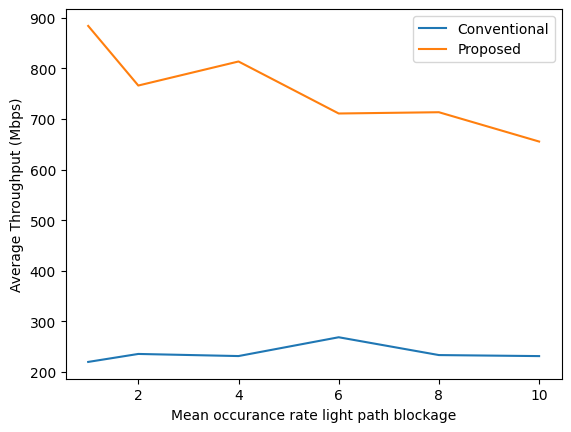

In [3]:
x1 = [1,2,4,6,8,10]
y1 = [219.57424387505597,235.35126491845972,231.1728382890945,268.37015041603314,233.12358048811774,231.0953126475178]
y2 = [884.2071576906355,766.2872658073504,813.8466174876554,710.9811791069699,713.4887047138029,655.5018099589936]
plt.plot(x1, y1, label =  "Conventional")
plt.plot(x1, y2, label = "Proposed")
plt.legend()
plt.xlabel('Mean occurance rate light path blockage')
plt.ylabel('Average Throughput (Mbps)')

In [9]:
# plt.imsave('channel_gain_nlos_mids_125_375.png', d_125_375)

<Figure size 640x480 with 0 Axes>

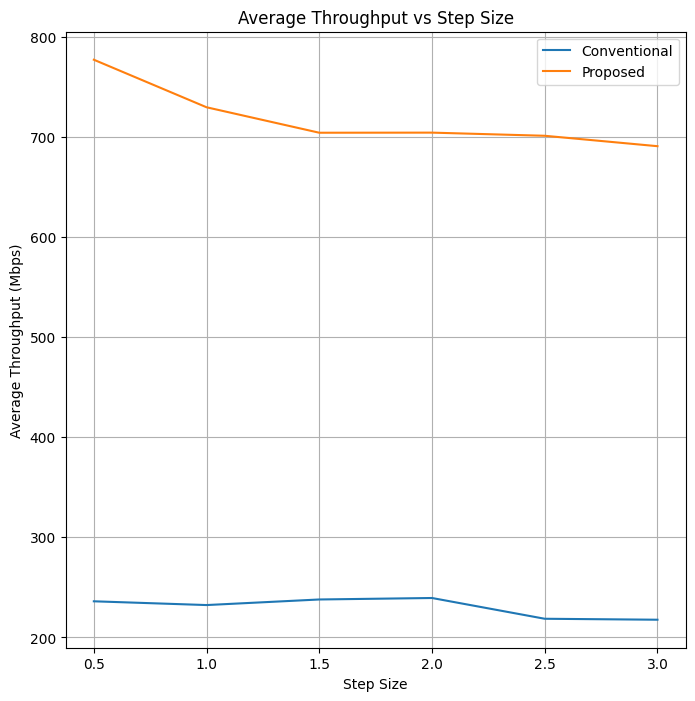

In [3]:
import numpy as np
import matplotlib.pyplot as plt

step_sizes = [0.5, 1, 1.5, 2, 2.5, 3]
all_avg_throughputs_proposed =  [776.9442873327106, 729.4602048366222, 704.0375951056822, 704.1381197264243, 700.9983421527124, 690.5962989524083]
all_avg_throughputs_conventional =  [236.1354245457723, 232.38281178853396, 237.95518610300732, 239.42972259288567, 218.69977038543396, 217.7388815680769]

# Plot steps vs throughputs for both methods
plt.figure(figsize=(8, 8))
plt.plot(step_sizes, all_avg_throughputs_conventional, label='Conventional')
plt.plot(step_sizes, all_avg_throughputs_proposed, label='Proposed')
plt.title('Average Throughput vs Step Size')
plt.xlabel('Step Size')
plt.ylabel('Average Throughput (Mbps)')
plt.legend()
plt.grid(True)
plt.show()
